In [1]:
# MNIST Digit Recognizer Using CNN

**Importing the necessary libraries**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.animation import FuncAnimation

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [3]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [4]:
train.shape

(42000, 785)

In [5]:
test.shape

(28000, 784)

In [6]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
Y_train = train["label"]

In [8]:
X_train = train.drop(labels = ["label"],axis = 1) 
del train

/tmp/ipykernel_23/2672232456.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('plasma')


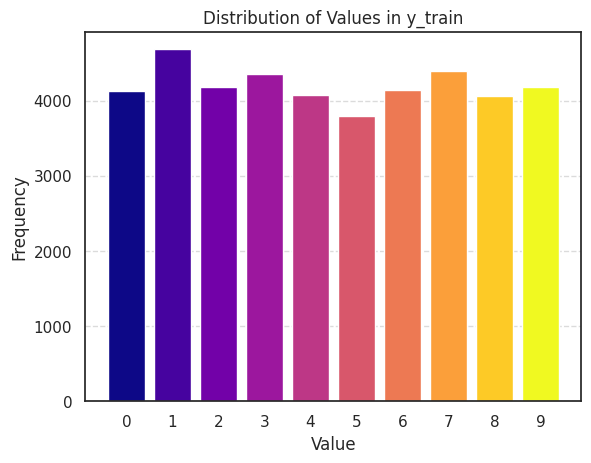

In [9]:
unique_values, counts = np.unique(Y_train, return_counts=True)
cmap = plt.cm.get_cmap('plasma')

plt.bar(unique_values, counts, color=cmap(np.linspace(0, 1, len(unique_values))))
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Values in y_train')
plt.xticks(unique_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [10]:
# It's a blanced Dataset

# Checking for missing Data Points

**Data Preprocessing**

In [11]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [12]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

# Normalization

In [13]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

# Reshape

In [14]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)


Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

# Label Encoding


In [15]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

# Splitting the Data

In [16]:
random_seed = 2

In [17]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

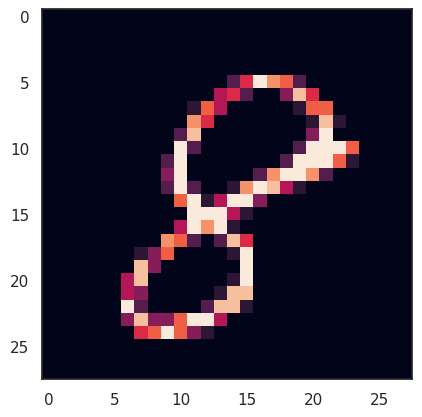

In [18]:
plt.imshow(X_train[0])

In [19]:
Y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

# Convolutional Neural Network

In [20]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [22]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [23]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [24]:
epochs = 30
batch_size = 86

# Data Augumentation

In [25]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

# Model Training

In [26]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(X_val, Y_val),
                    verbose=1,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    callbacks=[learning_rate_reduction])

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733150915.639267      71 service.cc:145] XLA service 0x7e9d5404a400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733150915.639355      71 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733150915.639362      71 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  8/439 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.1056 - loss: 2.3095

I0000 00:00:1733150921.972183      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.7203 - loss: 0.8239 - val_accuracy: 0.9743 - val_loss: 0.0892 - learning_rate: 0.0010
Epoch 2/30
  1/439 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9419 - loss: 0.2576

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.9419 - loss: 0.2576 - val_accuracy: 0.9748 - val_loss: 0.0679 - learning_rate: 0.0010
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9574 - loss: 0.1408 - val_accuracy: 0.9867 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - accuracy: 0.9651 - loss: 0.1351 - val_accuracy: 0.9867 - val_loss: 0.0487 - learning_rate: 0.0010
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9695 - loss: 0.1002 - val_accuracy: 0.9917 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 6/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.9884 - loss: 0.1448 - val_accuracy: 0.9902 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9762 - loss: 0.0780 - val_accuracy: 0.9886 - val_loss: 0.0337 - learning_rate: 0.0010
Epoch 8/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.9767 - loss: 0.0899

# Model Evaluation

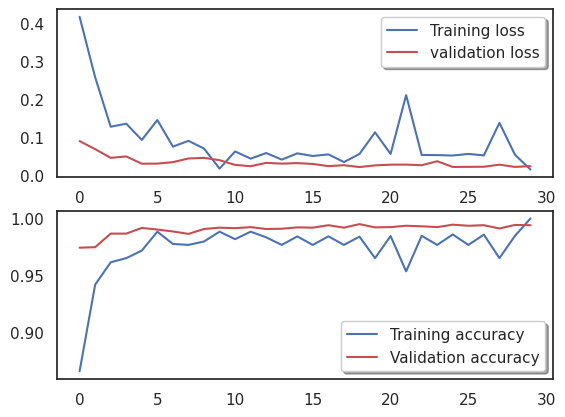

In [27]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

**Confusion Matrix**

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


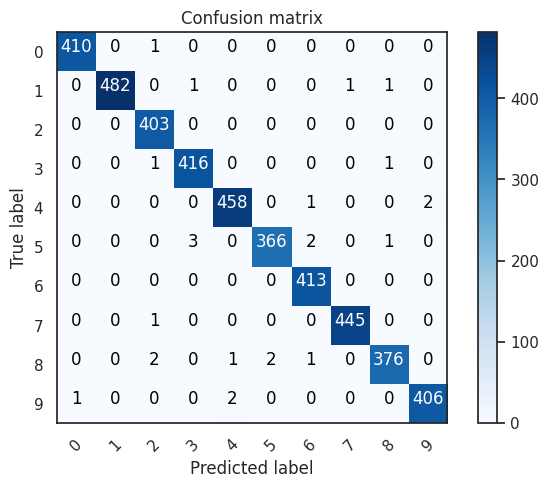

In [28]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))